In the US, all financial transaction consumers make are tracked and aggregated into features that describe their financial history. These features can then be used in order to predict how likely a person is to pay back their debts. Many US-based platforms offer unsecured loans, meaning that if a consumer stops paying while there is still outstanding debt (this is called a **charge off** or **defaulting** on the loan) the platform has no legal means for getting their money back, but the consumers' credit score is damaged. Charge-offs are the main risk lenders face, as they greatly decrease the loan's (or more generally, the loan portfolio's) total yield.

In this exercise we will use these credit features in order to predict which loans are likely to CO.

# Loading the data

First we will start by loading the data we will work with during this exercise.  
The data contains information about each loan.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Load the dataset and take a look at it

In [2]:
from pagayapro.paths.data_paths import ASSIGNMENT4_DATA
import os

In [3]:
data = pd.read_parquet(os.path.join(ASSIGNMENT4_DATA,"prosper_data.parquet"))


In [4]:
data.filter(regex='.*term.*')

""
id
733477
768878
742473
738121
733109
...
738916
754430
755852


In [5]:
data.head()

,all804,rep501,hr24s,rt24s,iln703,hr06s,g099a,iln720,percent_funded,hr09s,...,re102s,bac302,credit_score,int_rate,monthly_pmt,occupation,borrower_city,co_mob,co_amount,issue_date
id,,,,,,,,,,,,,,,,,,,,,
733477,4.0,0.0,-1.0,1.0,52.0,-1.0,-1.0,9999.0,1.0,-1.0,...,5183.0,5681.0,720.0,13.15,607.79,Other,Hialeah,NaN,0.000000,2017-01-31
768878,0.0,0.0,-1.0,1.0,101.0,-1.0,-1.0,9999.0,1.0,-1.0,...,6450.0,6450.0,720.0,13.75,510.84,Professional,MARIETTA,NaN,0.000000,2017-03-31
742473,0.0,1.0,-3.0,-6.0,72.0,0.0,-1.0,54.0,1.0,0.0,...,1778.0,2029.0,660.0,14.25,205.80,None,SAGLE,14.0,4115.149902,2017-02-28
738121,3.0,0.0,-1.0,-1.0,38.0,-1.0,-1.0,9999.0,1.0,-1.0,...,7680.0,7066.0,720.0,11.30,493.21,Waiter/Waitress,QUINCY,NaN,0.000000,2017-02-28
733109,3.0,0.0,-1.0,-1.0,87.0,-1.0,-1.0,9999.0,1.0,-1.0,...,6133.0,6133.0,700.0,18.15,119.55,Tradesman - Carpenter,JUNEAU,NaN,0.000000,2017-01-31


In [6]:
data.shape

(40249, 54)

In [7]:
data['co_mob'].unique()

array([nan, 14., 23.,  9., 21., 12.,  8.,  4., 20.,  2.,  7., 25.,  5.,
       13., 10., 18., 27., 16., 24., 29., 35., 17., 26., 22., 32., 33.,
       34., 11., 15., 31.,  6., 19., 28., 30.,  3.,  1., 39., 37., 40.,
       36., 41., 43., 38., 46., 42.])

# Exploratory Data Analysis

So as you did in the previous exercise, the purpose of the next section is getting to know the data and analyzing it.  
You need to understand the data and what is missing in order to find which data preparation steps are required.

In this exercise, we are training a classification model to predict whether or not a loan will repay in full. For this we have 2 columns, co_mob, and co_amount.
**co_mob, stands for: "Charge Off Month On Book".**  
A loan is considered a "charge-off" (AKA "default") if the person stopped paying but still has outstanding debt.  
The "month on book" (mob) is the number of months since the originataion of the loan.  
CO_mob (the charge-off month), is the first month after which there are no more payments (e.g., if someone pays in the first month, misses a payment in the second month, then pays months 3-5 and stops paying completely, his co_mob would be 6, not 2).
co_amount is the amount of outstanding debt lost due to the charge-off.

The main purpose of this exercise is to build a charge-off classification model, predicting which loans will not fully repay their debt.
So, the first thing to do is get to know our 'co_mob' feature.  
Let's plot its distribution in a histogram.

In [8]:
def plot_single_density_histogram(data,colors='firebrick',x_lable='x',y_lable='y',titles=[],generla_title='', remove_outliers= False):
    
    bins = int(2 * np.sqrt(len(data.unique())))
    plt.figure(figsize=(10,6))

    plt.hist(data, bins=bins,
             density=True,
             alpha=0.5, color=colors, edgecolor='k', label='noisy')


    median = data.median()
    mean = data.mean()

    plt.axvline(median,  linestyle='dashed', linewidth=3, alpha=0.5, color=colors)
    plt.axvline(mean, linewidth=3, color=colors)
    plt.xlabel(x_lable)
    plt.ylabel(y_lable)
    plt.grid(True)

    plt.title(generla_title)
    plt.legend()
    
    
    patches  = []

    plt.legend(handles=patches)

In [9]:
df_list = [data]
color_list = ['skyblue','firebrick']
df_title_list = ['co mob']

* We can see that most of the people that charge off do it in the reletievly early phase of the loan:
    - that makes sense because it is less logical to loose the credit score after most of the loan was already paid

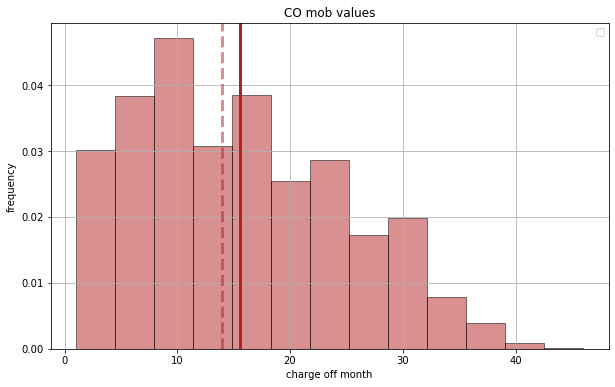

In [10]:
plot_single_density_histogram(data.co_mob,'firebrick', 'charge off month','frequency',\
                       [title + " - credit_score" for title in df_title_list], generla_title="CO mob values")

Note, the histogram of CO_MOB is not the probabilty of CO in that mob. If a loan was not charged-off (it was paid in full or pre-paid), its co_mob would be NaN and it would not appear in this graph. Therefore, this graph describes $ P(\text{co_mob} | \text{the loan is a charge-off}) $.

As pointed out above, a loan that did not CO will have a nan co_mob. Let's use that to make our target and drop it from the data

In [11]:
y = 1 - data.co_mob.isna()
data.drop(columns=['co_mob'],inplace=True)
data.shape

(40249, 53)

## Features types

Present the data types of each feature

- most of the data consists of numbers, occupation, borrower_city and issue_data are of type object.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40249 entries, 733477 to 739533
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   all804                  40249 non-null  float64       
 1   rep501                  40249 non-null  float64       
 2   hr24s                   40249 non-null  float64       
 3   rt24s                   40249 non-null  float64       
 4   iln703                  40249 non-null  float64       
 5   hr06s                   40249 non-null  float64       
 6   g099a                   40249 non-null  float64       
 7   iln720                  40249 non-null  float64       
 8   percent_funded          40249 non-null  float64       
 9   hr09s                   40249 non-null  float64       
 10  loan_amnt               40249 non-null  float64       
 11  rev401                  40249 non-null  float64       
 12  debt_to_income          40249 non-null  float

Let's take a look at the non-numeric features (you can use pd.DataFrame.select_dtypes); what are they?

In [13]:
data.select_dtypes(exclude=np.number)

,occupation,borrower_city,issue_date
id,,,
733477,Other,Hialeah,2017-01-31
768878,Professional,MARIETTA,2017-03-31
742473,None,SAGLE,2017-02-28
738121,Waiter/Waitress,QUINCY,2017-02-28
733109,Tradesman - Carpenter,JUNEAU,2017-01-31
...,...,...,...
738916,Nurse's Aide,Victorville,2017-02-28
754430,Skilled Labor,Mora,2017-03-31
755852,Food Service,HARVEY,2017-03-31


So, we have 3 non-numeric features: borrower_city, issue_date and occupation. Let's handle them.

### Borrower city

How many loans come from each city? 

CHICAGO         284
HOUSTON         250
Las Vegas       222
LAS VEGAS       213
LOS ANGELES     210
               ... 
SUTTER CREEK      1
SHINGLE SPGS      1
GALLATIN          1
CLIFTON PARK      1
Loris             1
Name: borrower_city, Length: 9560, dtype: int64


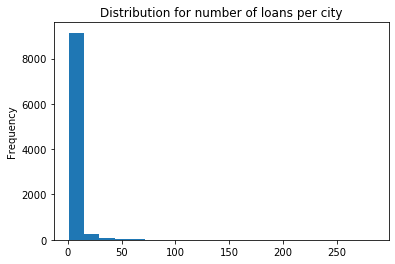

In [14]:
data['borrower_city'].value_counts().plot(kind='hist',xlabel="number of loans per city",ylabel='number of cities with number of loans',bins=20,title='Distribution for number of loans per city');
print(data['borrower_city'].value_counts())

This is a categorical feature with almost all distinct values (~10,000 values in 40,000 rows), so it is unlikely that it can be useful in predictions. Also, it's not nice to discriminate based on ones geography, let's drop it!

In [15]:
data.drop(columns=['borrower_city'],inplace=True)

### Issue date

Issue date is ordinal, so we can label encode it (you can use sklearn.preprocessing.LabelEncoder or OrdinalEncoder)

In [16]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
data['issue_date'] = enc.fit_transform(data.issue_date)
data.issue_date

id
733477    1
768878    3
742473    2
738121    2
733109    1
         ..
738916    2
754430    3
755852    3
763440    3
739533    2
Name: issue_date, Length: 40249, dtype: int64

### Occupation

Occupation is not ordinal, but we can target encode it. That is, for each category, replace it with the numeric value of the mean of the target over all elements that belong to that category. However, we first need to split into train and test in order to compute the encoder only on the train set.

## Split to train and test

As you already know, we need to split our data to train and test.
So.. let's make a 70/30 split!

Set you training and test sets to be X_train, y_train, X_test and y_test.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

Find the number of rows and columns in your training and test sets:

In [18]:
X_train.shape

(28174, 52)

In [19]:
X_test.shape

(12075, 52)

### Back to the occupation column

Now that we have a train set we can target encode the occupation feature. Compute the encoding on the train set.

In [20]:
# TODO - re think treating None as an occupation
taget_mean_by_occupation_dict = {}

for occupation in X_train['occupation'].unique():
    taget_mean_by_occupation_dict[occupation] = y_train[data['occupation'] == occupation].mean()
    
taget_mean_by_occupation_dict[None] =   y_train[data['occupation'].isna()].mean()
taget_mean_by_occupation_dict

{'Military Enlisted': 0.22085889570552147,
 'Professional': 0.17054545454545456,
 None: 0.24371993586317478,
 'Clerical': 0.21007371007371006,
 'Engineer - Mechanical': 0.14826498422712933,
 'Sales - Retail': 0.22119205298013245,
 'Teacher': 0.14733178654292342,
 'Laborer': 0.26956521739130435,
 'Construction': 0.2029816513761468,
 'Retail Management': 0.21470588235294116,
 'Other': 0.21363482956463045,
 'Attorney': 0.1164021164021164,
 'Administrative Assistant': 0.19072164948453607,
 'Psychologist': 0.06818181818181818,
 'Student - College Graduate Student': 0.05555555555555555,
 'Engineer - Electrical': 0.1822429906542056,
 'Executive': 0.16619452313503305,
 'Skilled Labor': 0.23567567567567568,
 'Nurse (LPN)': 0.20224719101123595,
 'Student - Community College': 0.25,
 'Clergy': 0.26,
 'Accountant/CPA': 0.14751552795031056,
 'Food Service': 0.2674897119341564,
 'Computer Programmer': 0.1043115438108484,
 'Nurse (RN)': 0.14891041162227603,
 "Nurse's Aide": 0.25,
 'Car Dealer': 0.252

In [21]:
def target_encode_occupation(occupation):
    return taget_mean_by_occupation_dict[occupation]

Use the encoder to transform occupation in both the train and test sets.

In [22]:
X_train['occupation'] = X_train['occupation'].apply(target_encode_occupation)
X_test['occupation'] = X_test['occupation'].apply(target_encode_occupation)

In [23]:
X_train['occupation'].sort_values().unique()

array([0.        , 0.04545455, 0.04761905, 0.05555556, 0.06818182,
       0.0952381 , 0.10431154, 0.10714286, 0.11538462, 0.11594203,
       0.11640212, 0.12      , 0.12121212, 0.125     , 0.13636364,
       0.14035088, 0.14130435, 0.14473684, 0.14733179, 0.14751553,
       0.14826498, 0.14891041, 0.15555556, 0.15733333, 0.15825375,
       0.16129032, 0.16619452, 0.16901408, 0.17054545, 0.17647059,
       0.17808219, 0.18224299, 0.19072165, 0.20224719, 0.20298165,
       0.2037037 , 0.21007371, 0.21052632, 0.21173469, 0.21363483,
       0.21470588, 0.21621622, 0.2208589 , 0.22119205, 0.221843  ,
       0.22222222, 0.22340426, 0.22346369, 0.23567568, 0.23741007,
       0.23943662, 0.24008811, 0.24371994, 0.25      , 0.25242718,
       0.25560538, 0.26      , 0.26153846, 0.26545842, 0.26748971,
       0.26956522, 0.28671329, 0.4       , 0.5       , 0.52941176,
       0.66666667, 1.        ])

In [24]:
X_test['occupation'].sort_values().unique()

array([0.        , 0.04545455, 0.04761905, 0.05555556, 0.06818182,
       0.0952381 , 0.10431154, 0.10714286, 0.11538462, 0.11594203,
       0.11640212, 0.12      , 0.12121212, 0.125     , 0.13636364,
       0.14035088, 0.14130435, 0.14473684, 0.14733179, 0.14751553,
       0.14826498, 0.14891041, 0.15555556, 0.15733333, 0.15825375,
       0.16129032, 0.16619452, 0.16901408, 0.17054545, 0.17647059,
       0.17808219, 0.18224299, 0.19072165, 0.20224719, 0.20298165,
       0.2037037 , 0.21007371, 0.21052632, 0.21173469, 0.21363483,
       0.21470588, 0.21621622, 0.2208589 , 0.22119205, 0.221843  ,
       0.22222222, 0.22340426, 0.22346369, 0.23567568, 0.23741007,
       0.23943662, 0.24008811, 0.24371994, 0.25      , 0.25242718,
       0.25560538, 0.26      , 0.26153846, 0.26545842, 0.26748971,
       0.26956522, 0.28671329, 0.4       , 0.5       , 0.52941176,
       0.66666667, 1.        ])

# Logistic Regression - Assumptions

As with the linear regression model, the logistic regression model also has assumptions that need to be met:
1. The target variable is binary.
2. There is no multicollinearity among the features.
3. A linear relationship between the features and the logit of the target.  
 $target \sim Bernouli(p(X))$ where $logit(p_{\beta}(X)) = X\beta$ or, equivalently, $p_{\beta}(X) = logit^{-1}(X\beta)=\frac{\exp(X\beta)}{1+\exp(X\beta)}.$

## Exploring the target variable

Let's check how many charge offs we have:

In [25]:
y_train.value_counts()

0    22508
1     5666
Name: co_mob, dtype: int64

Remember: True refers to charge-off, and False refers to no charge-off.

What is the percentage of loans with CO?

In [26]:
y_train.mean()

0.20110740398949387

In [27]:
y_test.mean()

0.20314699792960664

Compute the (absolute) correlations between each feature and the target

In [28]:
temp_data = data.copy()
temp_data['target'] = y
temp_data[temp_data.columns[1:]].corr()['target'][:].abs().sort_values()

hi57s                     0.001745
percent_funded            0.002263
loan_amnt                 0.011670
g099a                     0.011695
hr12s                     0.012658
st27s                     0.013400
hr24s                     0.015608
rep501                    0.016829
funding_threshold         0.019227
rt24s                     0.021112
all780                    0.022452
issue_date                0.028775
ale724                    0.029720
g230s                     0.031156
iln724                    0.032842
g099s                     0.032847
g094s                     0.033156
ale720                    0.034030
aut720                    0.034748
in36s                     0.042018
hr09s                     0.045606
iln740                    0.045852
hr06s                     0.045914
iln720                    0.050751
monthly_pmt               0.054308
iln703                    0.055294
g104s                     0.055845
all301                    0.080178
mt36s               

Okay, so co_amount is, unsurprisingly, very correlated with the label. For the moment, though, let's leave it inside the trainig set and see how it effects our results.

Plot the distributions of the next two most correlated features, conditioned on the target varible (i.e. one plot for each class in that target; you can use `hue=target` when using the seaborn suite). 

* We can see that there are over all highr credit score and lower interest rates in the no co  population

In [29]:
import matplotlib.patches as mpatches

def plot_density_histogram(data_list,colors=['firebrick','skyblue'],x_lable='x',y_lable='y',titles=[],func_flag='hist',generla_title='', remove_outliers= False):
    
    bins = int(np.sqrt(len(data_list[0].unique())))

    plt.figure(figsize=(10,6))
    print(bins)
    for i, data in enumerate(data_list):
    

        if func_flag == 'hist':
            plt.hist(data, bins=bins,
                     density=True,
                     alpha=0.5, color=colors[i], edgecolor='k', label='noisy')
        else:
            sns.distplot(data,color=colors[i],kde=True,bins=bins)
            
        median = data.median()
        mean = data.mean()
        
        plt.axvline(median,  linestyle='dashed', linewidth=3, alpha=0.5, color=colors[i])
        plt.axvline(mean, linewidth=3, color=colors[i])
        plt.xlabel(x_lable)
        plt.ylabel(y_lable)
        if remove_outliers:
            lower_lim,upper_lim, precentage_of_out_liars = remove_out_liars(data)
            titles[i] =  titles[i] + "  (Precent of outliars removed is: {}%)".format(str(np.round(100*precentage_of_out_liars,2)))
            plt.xlim(lower_lim,upper_lim)
        plt.grid(True)

        plt.title(generla_title)
    plt.legend()
    
    
    patches  = []
    for i,text in enumerate(titles):
        patches.append(mpatches.Patch(color=colors[i], label=titles[i]))
    plt.legend(handles=patches)

In [30]:
co_data = temp_data.query('target == 1')
no_co_data = temp_data.query('target == 0')
data_list = [co_data,no_co_data]
color_list = ['skyblue','firebrick']
df_title_list = ['co population','no co population']
co_data.credit_score.unique()

array([660., 760., 700., 680., 740., 640., 720., 780., 620., 600., 800.,
       820.])

3


No handles with labels found to put in legend.


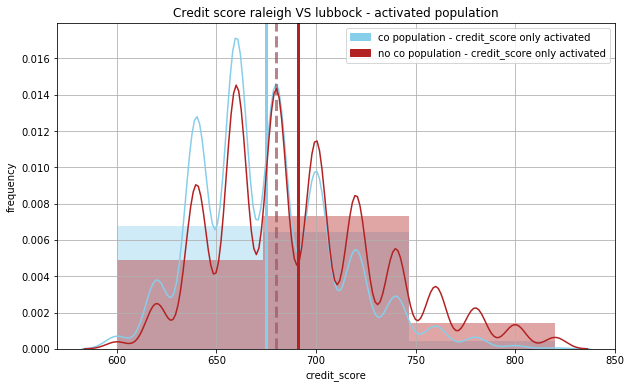

In [31]:
plot_density_histogram([data.credit_score for data in  data_list],color_list, 'credit_score','frequency',\
                       [title + " - credit_score only activated" for title in df_title_list],generla_title = "Credit score raleigh VS lubbock - activated population",func_flag='kde')

8


No handles with labels found to put in legend.


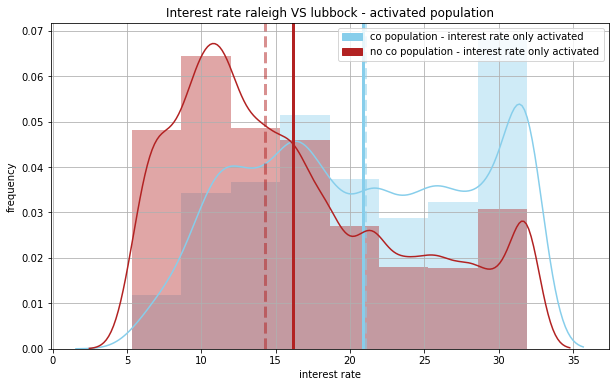

In [32]:
plot_density_histogram([data.int_rate for data in  data_list],color_list, 'interest rate','frequency',\
                       [title + " - interest rate only activated" for title in df_title_list],generla_title = "Interest rate raleigh VS lubbock - activated population",func_flag='kde')

## Multicollinearity

You are already familiar with the concept of multicollinearty from assignment 3.  

Reminder:
* Multicollinearity occurs when two or more explanatory variables are highly correlated to each other,\
  such that they do not provide unique or independent information in the regression model.  
  If the degree of correlation is high enough between variables, it can cause problems when fitting and interpreting the model. 

Multicollinearity can significantly impair the performance of logistic regression, so let's test for it and remove it

(You can use seaborn.clustermap to vizualize the correlation matrix)

<Figure size 2160x2160 with 0 Axes>

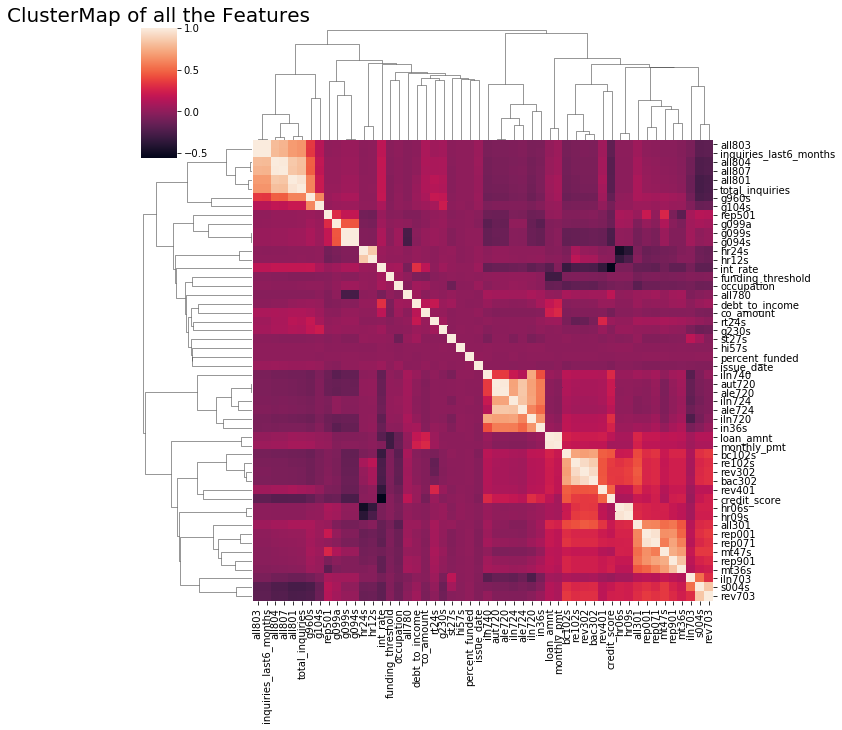

In [33]:
plt.figure(figsize=(30, 30))
sns.clustermap(X_train.corr(), xticklabels=True, yticklabels=True)
plt.title("ClusterMap of all the Features", fontsize = 20)
plt.show();

In the heatmap we can see several features that are highly correlated to others. There are more involved ways for choosing which features to keep, but in this case we will simply drop those features which are more correlated to other features as well. Select a set of features that are strongly correlated to other features and drop them.

In [34]:
# Remove one of each pair with a correlation of more then correlation_threshold
# TODO - optimize the threshold for co relation:
correlation_threshold = 0.8
max_index = 0
corr_matrix = X_train.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

correlation_sorted = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
for i in range(len(correlation_sorted)):
    if(correlation_sorted[i] < correlation_threshold):
        max_index = i
        break
        
correlated_features = set([tupple for tupple in correlation_sorted.index[0:i]])
print(correlated_features)

{('rev302', 'bac302'), ('loan_amnt', 'monthly_pmt'), ('hr06s', 'hr09s'), ('rev302', 're102s'), ('iln724', 'ale724'), ('ale724', 'ale720'), ('all807', 'total_inquiries'), ('hr24s', 'hr12s'), ('s004s', 'rev703'), ('aut720', 'ale724'), ('all804', 'inquiries_last6_months'), ('all801', 'total_inquiries'), ('aut720', 'ale720'), ('all804', 'all807'), ('all804', 'all801'), ('all803', 'inquiries_last6_months'), ('all804', 'all803'), ('re102s', 'bac302'), ('rep001', 'rep071'), ('g099s', 'g094s'), ('all804', 'total_inquiries'), ('all807', 'all801'), ('rep901', 'mt36s')}


In [35]:
# Choose some of the corelated features and remoce them:
correlated_features_list = ['all804','aut720','g099s','rev302','monthly_pmt','hr06s','rep001','all801','all803', # Correlation > 0.9
                            'ale724','re102s','all807','s004s','hr24s','rep901'] # Correlation > 0.8

In [36]:
X_train.drop(columns=correlated_features_list,inplace=True)
X_test.drop(columns=correlated_features_list,inplace=True)

Make sure the correlation map looks closer to diagonal now.

<Figure size 2160x2160 with 0 Axes>

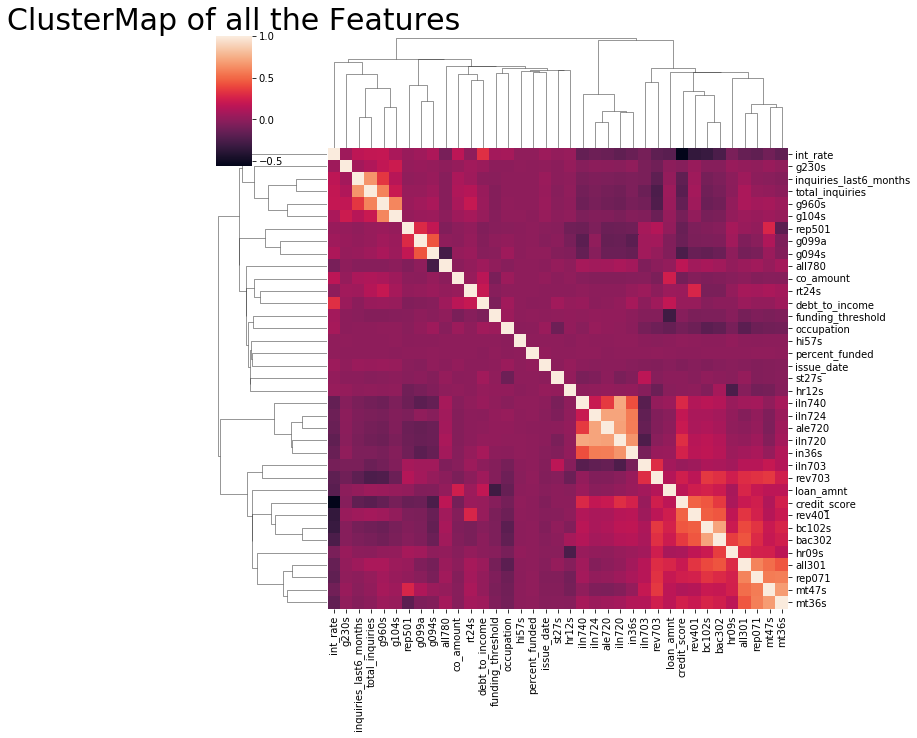

In [37]:
plt.figure(figsize=(30, 30))
sns.clustermap(X_train.corr(), xticklabels=True, yticklabels=True)
plt.title("ClusterMap of all the Features", fontsize = 30)
plt.show();

# Cleaning the data

Until now we got to know our data and checked if they meet the required assumptions.  
Now, let's start cleaning the data.

Find out the percentage of missing values (i.e. NaNs) in your dataset, and print them in ascending order. 

In [38]:
X_train.isna().sum()

rep501                    0
rt24s                     0
iln703                    0
g099a                     0
iln720                    0
percent_funded            0
hr09s                     0
loan_amnt                 0
rev401                    0
debt_to_income            0
st27s                     0
g960s                     0
g230s                     0
mt47s                     0
g094s                     0
g104s                     0
funding_threshold         0
hi57s                     0
all301                    0
hr12s                     0
bc102s                    0
iln740                    0
all780                    0
in36s                     0
mt36s                     0
iln724                    0
rev703                    0
inquiries_last6_months    0
rep071                    0
ale720                    0
total_inquiries           0
bac302                    0
credit_score              0
int_rate                  0
occupation                0
co_amount           

In [39]:
# No listing term column
for column in X_train.columns:
    if (len(X_train[(X_train[column] == 36) | (X_train[column] == 60)]) > 0.02 * len(X_train)):
        print(column)
     

How many missing values are the in the dataset? What's the percentage of rows without any missing features?

### There are no missing values in the data

If everything went smoothly, there should be no missing values here, so.. nothing left to do :)

## Outliers

If there are outliers, you can choose one of the following ways:
1. Use methods (such as XGBoost) which handle outliers inherently.
2. Remove them.
3. Replace them with a value like the mean/median.
4. Simply keep them in order to learn from them (but make a note about this when reporting the regression results).

Let's focus on two features we understand and find outliers in them:
1) loan_amnt - the amount of the loan in USD.
2) listing_term - the number months the loan was taken for.

In order to find outliers we will plot a box plot for each feature.

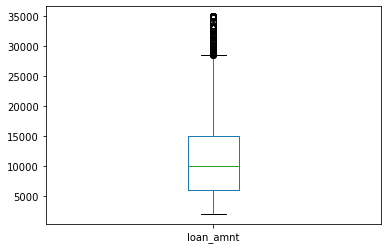

In [40]:
X_train['loan_amnt'].plot(kind='box')

In [41]:
# X_train['listing_term'].plot(kind='box')

There seem to be many outliers with large loan amounts. However, we do expect loan amount to have some very large values, and it is unlikely to expect it to be symmetric (why?).

We can, however, assume that the loan amount behaves log-normal (which means its Log behaves normally), therefore it might be more insightful to plot the Log of the feature. Plot a boxplot of the logarithm of SaleAmt.

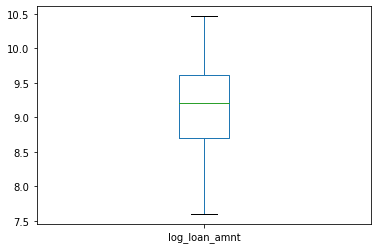

In [42]:
data['log_loan_amnt'] = np.log(data['loan_amnt'])
data['log_loan_amnt'].plot(kind='box')

X_train['log_loan_amnt'] = np.log(X_train['loan_amnt'])
X_test['log_loan_amnt'] = np.log(X_test['loan_amnt'])

This looks much better! 

Let's explore how many outliers we have in this feature. 
In general outlier is not a well-defined notion. One possible defition in our case would be loans whose loan amount is noticably higher or smaller than expected. For example in the case of a normal distribution, values more then $3*std$ from the mean are often considered outliers. A useful rule of thumb for finding outliers in many cases is by computing the interquantile range (IQR, i.e. the difference between the third and first quartile) and finding all loans whose log(loan amount) is more then some constant times the IQR from a given percentile.

Compute the IQR of the log of loan amount.

In [43]:
from scipy.stats import iqr

log_amount_iqr = iqr(X_train['log_loan_amnt'])
log_amount_iqr

0.9162907318741542

Compute the number of loans in X_train whose log(loan_amount) is more than $1.5*IQR$ below the 25th percentile of the feature.

In [44]:
X_train['log_loan_amnt'].quantile(q=0.25)

8.699514748210193

In [45]:
(X_train['log_loan_amnt'] < (X_train['log_loan_amnt'].quantile(q=0.25) - 1.5*log_amount_iqr)).sum()


0

Compute the number of loans in X_train whose log(loan_amount) is more than $1.5*IQR$ above the 75th percentile of the feature.

In [46]:
(X_train['log_loan_amnt'] > (X_train['log_loan_amnt'].quantile(q=0.75) + 1.5*log_amount_iqr)).sum()

0

Cool, it seems that there are no outliers according to this specific definition.

Replace the loan_amnt feature by its log:

In [47]:
X_train.drop(columns=['loan_amnt'],inplace=True)
X_test.drop(columns=['loan_amnt'],inplace=True)

# Preprocessing

We did most of the data preparation while working.  
The last thing we need to do is to handle categorical features (usually by creating dummy variables or label encoding).  
However, we already know there are no categorical features in our training set so our data is ready! 

# Model train

So, now that our data is ready, we can create and train our model. As we discussed in Section 3, we will use a logistic regression model for this purpose.
Use the `sklearn.linear_model.LogisticRegression` package to create your model. As we've seen in Assignment 1, regression models' performance improve if the data is standardized before fitting. In order to add a standartization step to your model you can use `sklearn.preprocessing.StandardScaler` and use `sklearn.pipeline.PipeLine` in order to run the two processes in sequence.

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [49]:
model = Pipeline([('scaler', StandardScaler()), ('lor', LogisticRegression())])

Fit your model to the training data

In [50]:
model.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lor', LogisticRegression())])

Let's check our model's performance. Our measure of accuracy would be the percentage of items in the test set for which the prediction is identical to the true value (i.e. the percantage of loans for which model predicted True for a CO loan or False for a non-CO loan).

You can either compute this value directly, or use `sklearn.metrics.accuracy_score`.

In [51]:
model.score(X_test, y_test)

0.9925465838509316

If all went according to plan, this should be way too good to be true, and make us suspicious. 
Let's have a closer at the trained model. Use `sklearn.linear_model.LogisticRegression`'s coef_ attribute in order to see the regression coefficient corresponding to each feature. By default - the coefficients appear in the same order as the corresponding columns appear in X_train.

Find a nice way to represent the coefficients and their respective column names and print it. How do the coefficients look?

In [52]:
model['lor'].coef_

array([[ 8.63095539e-02,  1.10884322e-01, -3.30837518e-02,
        -9.66674654e-02, -1.32501648e-01,  7.96675606e-02,
        -4.05452392e-02,  8.04544500e-02, -4.26744098e-02,
         1.76945191e-02, -3.77010376e-02,  3.22542744e-02,
         5.12410687e-02,  2.48471095e-02,  7.58003572e-02,
         1.10381672e-01,  4.66572016e-03, -7.59691237e-02,
         2.59501309e-02,  8.26182128e-03,  8.59806221e-02,
        -2.10314981e-02, -2.50015659e-02,  8.25198881e-02,
         1.03662029e-01, -8.19744171e-03,  2.03391604e-02,
        -1.64080858e-01,  1.78326379e-02,  6.37722593e-02,
        -7.73390712e-02,  6.20915734e-02,  1.59254952e-01,
         1.59776070e-01,  2.19784181e+01,  6.32991106e-02,
        -3.49262260e-01]])

Oh no! co_amount is not supposed to be a feature, it represents the performance of the loan and leaks information about the target (which we obviously won't have in real life before the loan is financed)! This is not surprising- we already saw that it is highly correlated with the target variable.

Let's fix it. Drop the co_amount column from the training and test sets.

In [53]:
X_train.drop(columns='co_amount',inplace=True)
X_test.drop(columns='co_amount',inplace=True)

Good, now let's retrain and see what we get. Fit the model to the new training set (without co_amount) and assess its performance, as above.

In [58]:
model.score(X_test, y_test)

0.7977639751552795

80% accuracy sure seems like a good start. HOWEVER, we saw that there are ~20% charge offs, so a model that predicts all False would essentially perform the same.
Let's look at a confusion matrix of our predictions vs. the true labels, to see if this is the case. Create a confusion matrix using `sklearn.metrics.plot_confusion_matrix`.

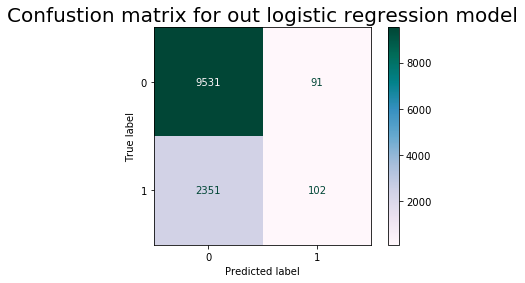

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


matrix = confusion_matrix(y_test,y_predict)
plot_confusion_matrix(model,X_test,y_test,cmap='PuBuGn')
plt.title("Confustion matrix for out logistic regression model",fontsize=20);
plt.show();


Yes, so it seems that our model predicts pretty much all as non-CO. In fact, let's compare to **really** 
predicting non-CO for all loans:

In [56]:
accuracy_score(y_test, [False] * len(y_test))

0.7968530020703933

Looks like even the accuracy of always predicting False is almost as good as our model. This is not great..

Moreover, **and this is very important**, in our case not all errors are equally important. A loan with 5% interest rate will yield ~16% of the original loan amount after 3 years ($(1+0.05)^3 -1 = 15.8$), if it repays in full. However, a loan that COs could cost us up to 100%! Therefore, it is **much more important** for us to correctly identify CO's than non-CO's.

Let's see how the accuracy looks if we weighted the COs as 5x (and it is plausible to give it even higher weights). Use `skelearn.metrics.accuracy_score`'s sample_weight parameter to add a weight of 5 to each True prediction of the model.

In [59]:
sample_weights = [1 if i == 0 else 5 for i in y_test]
accuracy_score(y_test, [False] * len(y_test),sample_weight=sample_weights)

0.43962169324256406

In [62]:
y_predict = model.predict(X_test)
sample_weights = [1 if i == 0 else 5 for i in y_test]
accuracy_score(y_test, y_predict,sample_weight=sample_weights)

0.45876547722392286

## Using a weighted model

Of course, the lower accuracy score in the last section is not the model's fault, because we didn't train it to predict with sample weights. But we can retrain the model and give COs higher weights then non-CO loans - let's see what that looks like

Create a linear regerssion model as above with a weight of 5 to each CO loan and 1 for non-CO loans. You can use `sklearn.linear_model.LogisticRegression`'s class_weights parameter for this.

In [75]:
model_weighted = Pipeline([('scaler', StandardScaler()), ('lor', LogisticRegression(class_weight={0:1,1:5}))])
model_weighted.fit(X_train,y_train)
y_predict = model_weighted.predict(X_test)


What is the model's accuracy score?

In [76]:
print(accuracy_score(y_predict,y_test))

0.5872463768115942


In [77]:
print(accuracy_score(y_predict,y_test,sample_weight=sample_weights))

0.6650066249371773


Let's see the precentage of false positive and true negatives using a confusion matrix.

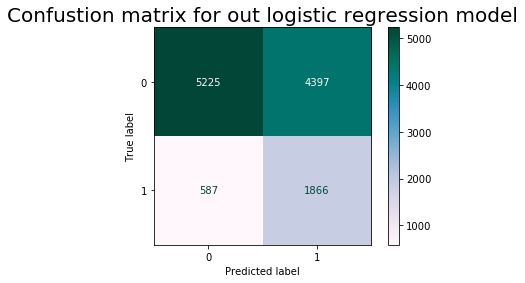

In [78]:
matrix = confusion_matrix(y_test,y_predict)
plot_confusion_matrix(model_weighted,X_test,y_test,cmap='PuBuGn')
plt.title("Confustion matrix for out logistic regression model",fontsize=20);
plt.show();

Looks like our model now predicts many more loans as CO than before. Now that we see that changing the weights improve desirable properties of the model, how do we know how to find the *optimal* weights? In fact, in our case we might be able to bypass this problem.

Our logistic regression model predicts the probability of each loan charging off and, by default, flags the loan as CO if it has more than 50% probability of charging off (and non-CO otherwise). Instead of trying various weights and seeing which loans have a probability > 0.5 under these weights, we can decide to label a loan as CO even for a predicted 25%. Or 10%. Or any other threshold. We can then plot the Reciever-Operator Curve (ROC) which tells us the TPR (True Positive Rate) vs. FPR (False Positive Rate) induced by each choice of threshold.

First, in order to see that, indeed, changing the weights is equivalent to changing the threshold instead, let's plot the predicted probabilities for the unwighted model compared with the weighted model and look at the correlation of predictions for both models. 
To obtain the predicted probabilities (instead of the T/F prediction) use the models' predict_proba attribute.

In [79]:
len(np.arange(len(X_train)))
len(model.predict_proba(X_train))
model.predict_proba(X_train)[0]

array([0.70693525, 0.29306475])

Create a scatter plot of the predicted probabilities of the unweighted model vs those of the weighted model.

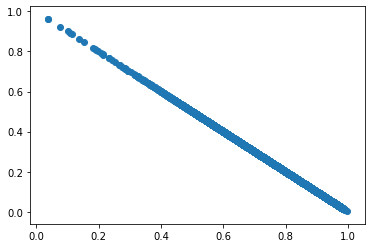

In [80]:
model_probs = model.predict_proba(X_train)

plt.scatter(model_probs[:,0],model_probs[:,1])

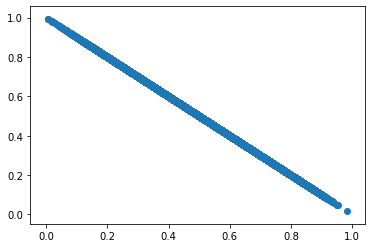

In [81]:
wieghted_model_probs = model_weighted.predict_proba(X_train)
plt.scatter(wieghted_model_probs[:,0],wieghted_model_probs[:,1])

In [ ]:
wieghted_model_probs.sort()

In [ ]:
model_probs.sort()

Compute the Spearman rank correlation between the predicted probabilities of the two models. A Spearman correlation is a good choice for this type of comparison, because it evaluates the degree to which the models agree about ranking the loans with respect to their probability of CO.

In [84]:
from scipy.stats import spearmanr

spearmanr(wieghted_model_probs,model_probs).correlation

array([[ 1.        , -1.        ,  0.99926474, -0.99926474],
       [-1.        ,  1.        , -0.99926474,  0.99926474],
       [ 0.99926474, -0.99926474,  1.        , -1.        ],
       [-0.99926474,  0.99926474, -1.        ,  1.        ]])

Cool, so we indeed get very good correlation. 

Now let's look at the ROC of this model. Use `sklearn.metrics.plot_roc_curve` to create a ROC of the first (unweighted) model.

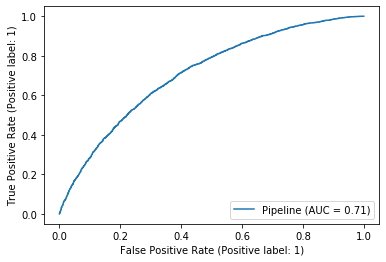

In [85]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model,X_test,y_test)

Now we know what our options are for trading-off FPR and TPR. The question remains - how do we know which tradeoffs are reasonable?
In our case there are other metrics we can use in order to test our model's performance. Our main goal for training this model is to maximize returns, so it makes sense to evaluate the performance of the model by measuring the performance of our portfolio. We will use [IRR](https://www.investopedia.com/terms/i/irr.asp) to measure the portfolio's yield.

# Computing IRR of different portfolios

In order to compute the IRR of our portfolio we need to get the cashflow (i.e. the payments made for each loan) for our portfolion. We have provided you with a dataframe of precalculated cashflows indexed according to your data.

In [86]:
cashflows = pd.read_parquet(os.path.join(ASSIGNMENT4_DATA,"prosper_cashflows.parquet"))

The following function receives a dataframe of cashflows and a list of indices and returns the IRR of the portfolio given by these indices.

In [87]:
import numpy_financial as npf
def get_portfolio_irr(cashflows, indices):
    """
    cashflows- a dataframe of cashflows 
    indices- pd.Series of T/F or a list of indices
    
    output: the yearly irr of the dataframe cashflows.loc[indices]
    """
    return (((npf.irr(cashflows.loc[indices].sum()) + 1) ** 12) - 1) * 100

In [88]:
cashflows.head()

,loan_amnt,actual_pmt1,actual_pmt2,actual_pmt3,actual_pmt4,actual_pmt5,actual_pmt6,actual_pmt7,actual_pmt8,actual_pmt9,...,actual_pmt65,actual_pmt66,actual_pmt67,actual_pmt68,actual_pmt69,actual_pmt70,actual_pmt71,actual_pmt72,actual_pmt73,actual_pmt74
id,,,,,,,,,,,,,,,,,,,,,
733477,-18000.0,0.000000,607.790466,607.789307,1215.580322,0.000000,607.789551,1215.580322,0.000000,1215.579712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
768878,-15000.0,0.000000,1021.680298,0.000000,1021.679565,510.840027,0.000000,1021.680176,510.840332,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
742473,-6000.0,205.799957,205.799881,205.800003,205.799957,205.800232,205.799835,205.800049,205.800232,205.800049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
738121,-15000.0,493.209686,493.210236,493.210052,493.209808,493.210510,493.209534,493.210327,493.210266,493.209961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
733109,-3300.0,119.549927,119.550064,119.549896,119.550003,119.550125,119.549942,119.550171,119.549805,119.550110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Compute the IRR of the test set:

In [ ]:
merged_train = X_train.merge(cashflows,how='left',on='id')
merged_test = X_test.merge(cashflows,how='left',on='id')

In [ ]:
assert merged_train['actual_pmt1'].isna().sum() == 0
assert merged_test['actual_pmt1'].isna().sum() == 0

In [98]:
get_portfolio_irr(cashflows,X_test.index)

3.8079640520308544

Now compute the IRR of all the loans in the test set which were predicted as non-CO:

In [103]:
y_predicted = model.predict(X_test)
indexes = X_test[y_predicted == 0].index
get_portfolio_irr(cashflows,indexes)

4.094035619522041

This is a small improvement, let's see what the x5 weights model looks like:

In [104]:
y_predicted = model_weighted.predict(X_test)
indexes = X_test[y_predicted == 0].index
get_portfolio_irr(cashflows,indexes)

6.149491231058168

This is a HUGE improvement! However, we haven't considered how much we had to reduce our volume to reach this return. Let's see what the effect is- compute the percentage of loans for the x5 weights model which managed are flagged as non-CO

In [105]:
print("number of loans predicted as non charge off are",1-y_predicted.mean())

number of loans predicted as non charge off are 0.4813250517598344


So this cost us giving up more than 50% of the portfolio. 

If we have a given amount of money we want to invest we might be willing to settle for a slightly lower return in order to increase the amount of money yielding this return. We can make a plot similar to the ROC, but trading off the IRR on the y-axis and the deployed volume on the x-axis. This will allow us to evaluate these metrics, and interpret them from a buisness standpoint.

Let's have a closer look at this trade-off. Use the model's predict_proba attribute to find the set of loans which pass a threshold of 5%, 10%, 15%, ... 95%. For each such set, compute its volume (i.e. sum over loan_amnt) and its IRR. Create a curve which shows the volume vs IRR of each choice of threshold.

In [190]:
X_test[model_weighted.predict_proba(X_test)[:,0] >= 0.90].index

Index(['752187', '736016', '738631', '769253', '737576', '765556', '725087',
       '726924', '747870', '745990', '737844', '719686', '723597', '745769',
       '771764', '748672', '747232', '725398', '735468', '722423', '728613',
       '747186', '748184', '743636', '718933', '741898', '726612', '737488',
       '752811', '763947', '723545', '774945', '721372', '741727', '736159',
       '721933'],
      dtype='object', name='id')

In [178]:
X_test.shape

(12075, 36)

[3.8129974124708754, 3.8355022302363873, 3.9842648370273404, 4.334120636978489, 4.676701200404709, 5.099339612681475, 5.319195188444348, 5.730961489237485, 5.968922819480915, 6.149491231058168, 6.1183698908681805, 6.130908065413232, 6.163997237617824, 6.531786221347913, 6.271035167444694, 6.27300147772345, 6.512232303231191, 6.7856790830268965, nan, nan]


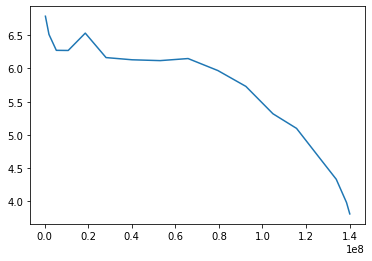

In [198]:

irr_list = []
loan_amnt_list =[]

for i in np.linspace(0.05,1.0,20):
    indices = X_test[model_weighted.predict_proba(X_test)[:,0] >= i].index
    IRR = get_portfolio_irr(cashflows,indices)
    loan_amnt = (np.exp(X_test.loc[indices,'log_loan_amnt'])).sum()
    irr_list.append(IRR)
    loan_amnt_list.append(loan_amnt)
print(irr_list)    
plt.plot(loan_amnt_list,irr_list)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
[5342835.975897058, 5366775.809879842, 5523153.125027193, 5803567.658967869, 5879538.881309267, 5898028.82985072, 5575974.868042541, 5294704.883223018, 4747098.166234113, 4048403.1714302474, 3242383.0122174327, 2461638.1865048115, 1735675.2931608304, 1216058.435016834, 676156.9961623102, 333617.4766998697, 126376.18470953542, 20981.11615434667, nan, nan]


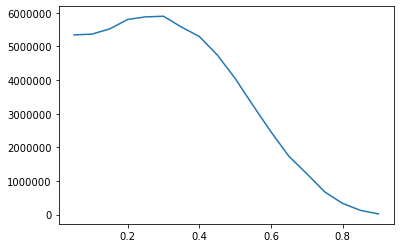

In [199]:
# Plot yearly gain as a function of threshold
X_values = np.linspace(0.05,1.0,20)
y_values = [a*b*0.01 for (a,b) in zip(loan_amnt_list,irr_list)]
plt.plot(X_values,y_values)
print(X_values)
print(y_values)

Now this graph shows us the tradeoff between the return and the deployed volume. Given this graph we are left with the buisness question of where along this tradeoff we wish to be, which will determine the threshold we should choose.

# Now share your model 

Now that your model is ready, it's time to create a package which streamlines it's usage.
Do the following:
* Inside the `pagayapro` repo, create a branch called `feature/{your_names}/co_classifier/`
* Inside `~/pagayapro/assignment3/`, create a folder called `models/{your_names}/` and in it a python package which contains a class for the model (you may choose the class's name). The class should have the attributes `fit`, `predict` and `predict_proba`.
* The attribute `fit` should accept two variable, X and y, preprocess them according to the steps you've undertaken in this notebook and fit a logistic regression model to the preprocessed data.
* The attribute `predict` should accept a test set X_test, preprocess it accrodingly, and return an array of boolean prediction for each row of X_test- True for CO and False for non-CO. The attribute `predict_proba` return the predicted probability of each row.
* Once you package is ready, push it to the repo. Ask your mentor for a review. Once the review is complete, rebase and merge your package to the repo.

# One last remark

An important thing we ignored in this exercise is that increased risk is not necessarily a bad thing, as a higher interest rate could compensate for it, with a premium. A portfolio that has 10% CO might be better than one that has 5% CO, if the average interest rate of the former is 20% and 10% for the latter. In the next assignment, we will attempt to use this observation to further improve our ability to choose a good portfolio.